Exercise 4: Lossy Image Compression
===============================

To complete the exercise, follow the instructions and complete the missing code and write the answers where required.  All points, except the ones marked with **(N points)** are mandatory. The optional tasks require more independet work and some extra effort. Without completing them you can get at most 75 points for the exercise (the total number of points is 100 and results in grade 10). Sometimes there are more optional exercises and you do not have to complete all of them, you can get at most 100 points.

## Introduction

In this exercise, you will implement several concepts from lossy image compression al

of the JPEG pipeline for image compression. The method is based on performing the [discrete cosine transform (DCT)](https://en.wikipedia.org/wiki/Discrete_cosine_transform) on 8x8 blocks, quantizing the resulting coefficients, then losslessly compressing them via entropy encoding. You will first familiarize yourself with the calculation and properties of the DCT by using it on 1D signals, then use its 2D variant to transform and reconstruct images. Finally, you will implement a rough version of the JPEG algorithm and check the reductions in space and quality of the compressed images.

In [1]:
# Run this cell to download the data used in this exercise
import zipfile, urllib.request, io
zipfile.ZipFile(io.BytesIO(urllib.request.urlopen("http://data.vicos.si/lukacu/multimedia/exercise4.zip").read())).extractall()

In [2]:
# Some initial imports
%matplotlib notebook

from matplotlib import pyplot as plt
import numpy as np
from skimage import data, io, color

## Assignment 1: Block Truncation Coding

One of the early lossy image compression approaches divides image into 4x4 blocks and encodes each block with a mean, a standard deviation and a binary image that denotes if each of the 16 pixels in the block is higher or lower than the mean value. This approach is called Block Truncation Coding and is in some respects a predecesor to more well known lossy image compression codecs, such as JPEG.

 * Load image `tiger.bmp` (convert it to grayscale) and divide it into 4x4 blocks. Since the image dimensions are not divisible by 4, use `np.pad` to make image bigger. Order blocks row-by-row and visualize blocks 3, 261, and 387.
 
   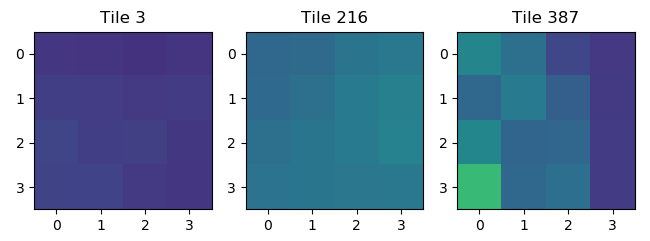

<IPython.core.display.Javascript object>


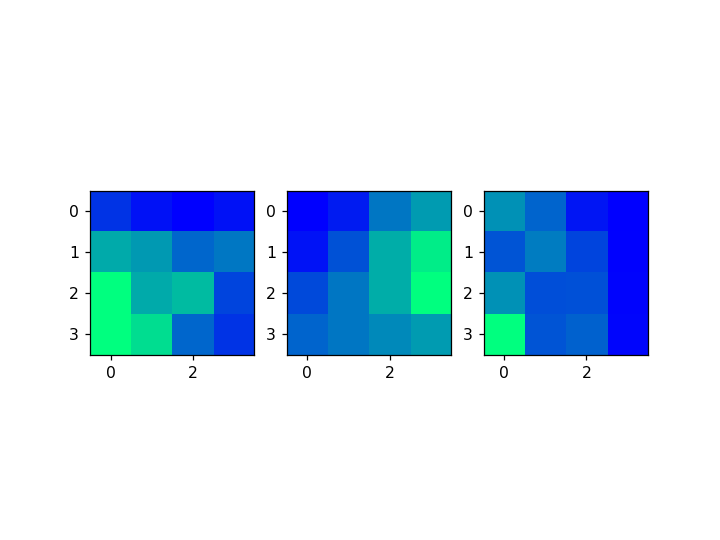

In [3]:
# https://cmparlettpelleriti.github.io/BTC.html

import math

I = color.rgb2gray(io.imread("tiger.bmp")) * 255

def padding(size, block_size):
    """ A helper function to calculate padding size. """
    return int(np.ceil(size / block_size) * block_size - size)

img = np.pad(I, ((0,padding(I.shape[0], 4)), (0,padding(I.shape[1], 4))))

# TODO
def image_to_blocks(img, block):
    tiles = []
    tile_count = 0
    for i in range(0, img.shape[0], block):
        for j in range(0, img.shape[1], block):
            tiles.append(np.floor(img[i:i+block, j:j+block]))
            tile_count += 1
    return tiles


tiles = image_to_blocks(img, 4)
#print("tiles: ", tile_count)
plt.figure()
plt.subplot(131)
plt.imshow(tiles[2], cmap = plt.cm.winter)
#plt.winter()
plt.subplot(132)
plt.imshow(tiles[215], cmap = plt.cm.winter)
plt.subplot(133)
plt.imshow(tiles[386], cmap = plt.cm.winter)
plt.show()

# def btc(img, block):
#     res = img.copy()
#     bitmap = img.copy()
#     tile_count = 0
    
#     for i in range(0, img.shape[0], block):
#         for j in range(0, img.shape[1], block):
#             temp = btc_block(img[i:i+block, j:j+block])
#             bitmap[i:i+block, j:j+block], res[i:i+block, j:j+block] = temp
#             if(tile_count == 3 or tile_count == 261 or tile_count == 378):
#                 plt.figure()
#                 plt.imshow(temp[0])
#                 plt.show()
#             tile_count +=1
#     return bitmap, res

# def btc_block(img_block):
#     m = img_block.shape[0] * img_block.shape[1]
#     h = float(np.sum(img_block) / (img_block.shape[0] * img_block.shape[1]))
#     h2 = float(np.sum(img_block ** 2) / (img_block.shape[0] * img_block.shape[1]))
#     sigma2 = np.var(img_block)
#     sigma = np.std(img_block)
#     q = img_block[np.where(img_block > h)].shape[0]
#     a = h - sigma * math.sqrt(float(q) / (m - q))
#     b = h + sigma * math.sqrt((m - q) / float(q))
#     bitmap = np.zeros((img_block.shape[0], img_block.shape[1]))
#     result = img_block.copy()
#     for i in range(0, img_block.shape[0]):
#         for j in range(0, img_block.shape[1]):
#             if (img_block[i, j] >= h):
#                 bitmap[i, j] = 1
#                 result[i, j] = round(b, 0)
#             else:
#                 result[i, j] = round(a, 0)
#     return bitmap, result

# I = np.pad(I, ((0,padding(I.shape[0], 4)), (0,padding(I.shape[1], 4))))

# # TODO
# bitmap, res = btc(I, 4)
# plt.figure()
# plt.imshow(bitmap)
# plt.show()

 * For each block compute the mean value and standard deviation of the values. Then use thresholding to determine which pixels are greater than the mean value. Write function `btc_compress` that accepts a grayscale image and returns a list of tuples containing mean, standard deviation and a list of 16 logical values. For the sixth block the output should be `(26, 5, [True, True, True, True, False, True, True, True, False, False, False, True, False, False, False, False])`

  **Question**: what is the compression ratio of the BTC coding? Does it change with the content of the image?

In [4]:
def btc_compress(img):
    tiles = image_to_blocks(img, 4)
    mean = []
    deviation = []
    log_values = []
                
    for i in range(len(tiles)):
        mean.append(np.floor(np.average(tiles[i])))
        
        temp = pow((tiles[i] - mean[i]),2)
        deviation.append(math.floor(math.sqrt(np.average(temp))))
        
        l_value = []
        ith_tile = tiles[i]
        for j in range(4):
            for k in range(4):
                if ith_tile[j][k] >= mean[i]:
                    l_value.append(True)
                else:
                    l_value.append(False)
        log_values.append(l_value)

        
    return [mean, deviation, log_values]

I = color.rgb2gray(io.imread("tiger.bmp")) * 255
img = np.pad(I, ((0,padding(I.shape[0], 4)), (0,padding(I.shape[1], 4))))
token = btc_compress(img)

print(token[0][5], token[1][5], token[2][5])

26.0 5 [True, True, True, True, False, True, True, True, False, False, False, True, False, False, False, False]


 * **(5 points)** Write function `btc_decompress` that accepts a list of tuples and image shape from the task above and returns a reconstructed image. Check the lecture slides for the reconstruction formulas. At the end, crop the padded pixels from the image. Test compression and decompression on the `tiger.bmp` image. Zoom in on an region to see the difference.
 
   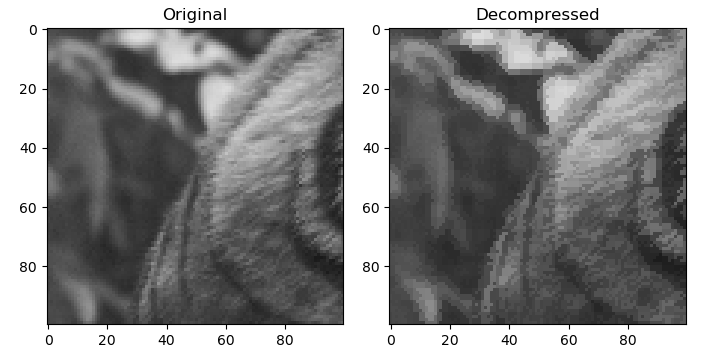

123009 101983
konec


<IPython.core.display.Javascript object>


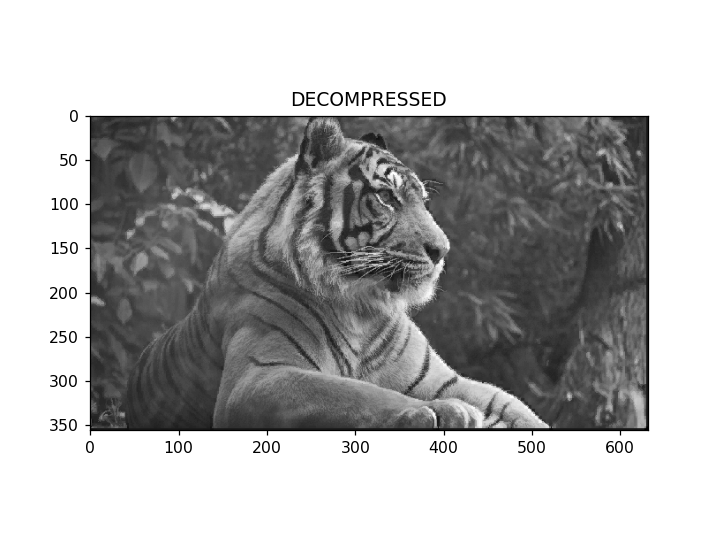

<IPython.core.display.Javascript object>


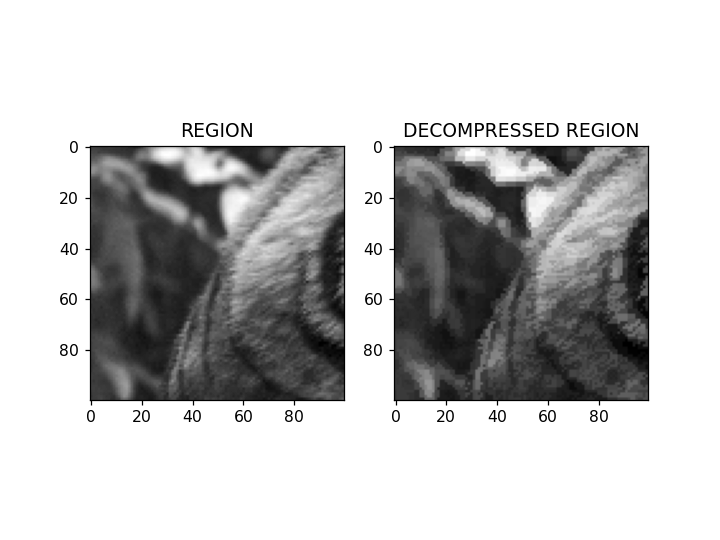

Text(0.5, 1.0, 'DECOMPRESSED REGION')

In [5]:
def btc_decompress(tokens, shape):
    tiles = image_to_blocks(img, 4)
    n_true = 0
    n_false = 0
    block = 4
    new_tiles = []
    
    for i in range(len(tiles)):
        is_true = sum(tokens[2][i])
        n_true += is_true
        n_false += (16 - is_true)
    print(n_true, n_false)
    
    assert n_true + n_false == 16*len(tiles)
    
    nov_img = img.copy()
    for i in range(len(tiles)):
        ith_tile = tiles[i]
        ith_mean = tokens[0][i]
        ith_deviation = tokens[1][i]
        ith_log_values = tokens[2][i]
        koren_n = math.sqrt(n_true // n_false)
        idx = 0
        
        for j in range(4):
            for k in range(4):
                if ith_log_values[idx]:
                    ith_tile[j][k] = ith_mean + (ith_deviation // koren_n)
                else:
                    ith_tile[j][k] = ith_mean - (ith_deviation * koren_n)
                idx += 1
        new_tiles.append(ith_tile)
    print("konec")
    
    idx = 0
    for i in range(0, img.shape[0], block):
        for j in range(0, img.shape[1], block):
            nov_img[i:i+block, j:j+block] = new_tiles[idx]
            idx += 1
    return nov_img

decompressed = btc_decompress(token, img.shape)
plt.figure()
plt.imshow(decompressed, cmap = plt.cm.gray)
plt.title("DECOMPRESSED")
plt.show()

region = img[100:200, 100:200]
region_d = decompressed[100:200, 100:200]
plt.figure()
plt.subplot(121)
plt.imshow(region, cmap = plt.cm.gray)
plt.title("REGION")
plt.subplot(122)
plt.imshow(region_d, cmap = plt.cm.gray)
plt.title("DECOMPRESSED REGION")

Assignment 2: Discrete Cosine Transform
--------

The discrete cosine transform used in JPEG standard is called DCT-II. The process expresses a (finite) sequence of data points as a sum of cosines with different frequencies (called basis functions). The result is a list of coefficients which can be used to reconstruct the original data. The most commonly used is DCT-II, also called "the DCT". Its inverse, DCT-III is called "the inverse DCT". Their formulas are as follows:

\begin{equation}
X_k = \sum_{n=0}^{N-1}x_n \cos{\Big(\frac{\pi}{N}\Big(n+\frac{1}{2}\Big)k\Big)}; \quad k = 0,\dots, N-1,\\
x_k = \frac{1}{N}X_0+\sum_{n=1}^{N-1}\frac{2}{N} \ X_n \cos{\Big(  \frac{\pi}{N}\ n\ \Big(  k+\frac{1}{2}  \Big)  \Big)}; \quad k = 0,\dots, N-1
\end{equation}

where $x_n$ denotes the $n$-th element of the input signal, while $N$ denotes the total number of elements of the input signal.



 * In DCT, the signal is expressed as a sum of cosines with different frequencies. Consider the length of sequence `N = 10` and plot the basis functions for sequences of this length. The number of basis functions must equal the number of data points (N). To make the plot look smoother you can tabulate the cosine function more accurately by adding more values, e.g. use `200` values instead `10` that are sufficient for computation of DCT. The result should look like this:

    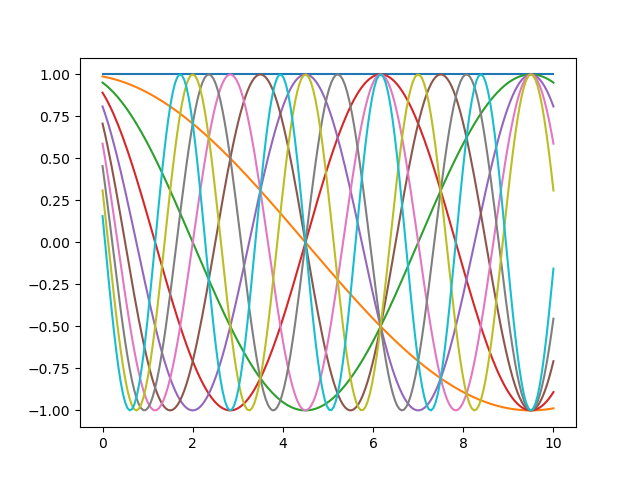

<IPython.core.display.Javascript object>


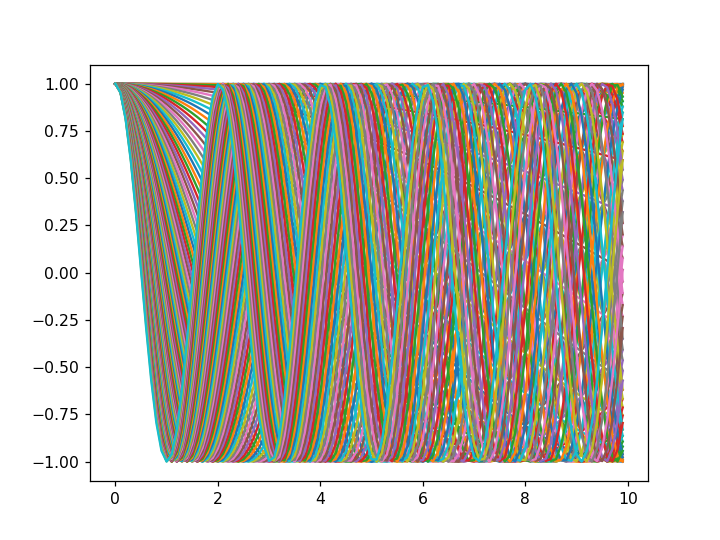

In [6]:
# TODO: Plot the basis functions
seq_len = np.arange(0, 10, step=0.1)
N = 100
n = np.arange(N)/(N*2)

plt.figure()
for i in n:
    cos = np.cos(2 * np.pi * i * seq_len)
    plt.plot(seq_len, cos)
plt.show()

 * Implement 1D DCT transform and its inverse. Implement the ``my_dct`` and ``my_idct`` functions that receive a signal and return the DCT coefficients (the sizes must match). Use the above formulas. Take note that these are the basic formulas. In practice, scaling factors are used to allow the transform to be expressed as matrix multiplication (see point <i>(d)</i>). You can test the correctness of your implementation by transforming a signal to frequency domain and back again. The result should be equal to the input signal (up to machine precision).

In [7]:
# TODO: Write a function my_dct that computes the 1D DCT transform of the 'input_signal'
def my_dct(signal):
    N = len(signal)
    n = np.arange(0, N, 1)
    K = np.arange(0, N, 1)
    X = np.zeros(N)
    
    for k in K:
         for xi in n:
            X[k] += signal[xi] * np.cos((np.pi/N) * (xi + 0.5) * k)
    return np.array(X)

input = [1, 4, 0, 3]
res = my_dct(input)
print(res)

[ 8.00000000e+00 -3.17025336e-01 -4.44089210e-16 -4.46088499e+00]


In [8]:
# TODO: Write a function my_idct that computes the inverse of the 1D DCT transform passed as 'input_signal'
def my_idct(signal):
    N = len(signal)
    n = np.arange(1, N, 1)
    K = np.arange(0, N, 1)
    X = np.ones(len(K)) * (signal[0]/N)
    
    for xi in K:
        cos = np.cos((np.pi/N) * n * (xi + 0.5))
        X[xi] += (2/N) * np.dot(signal[1:N], cos)
    return X

print(my_idct(res))

[1.0000000e+00 4.0000000e+00 4.4408921e-16 3.0000000e+00]


 * Visualize the signal reconstruction from the DCT coefficients. Perform the DCT (using `my_dct`) on a chosen signal (to make the process easier to follow, start with `y = np.sin(np.exp(x) * 0.2)`), then transform it back using `my_idct`. Plot the intermediate result. If performed correctly, the signal should in the end be fully reconstructed. Also plot the error between the original and the reconstuction.

    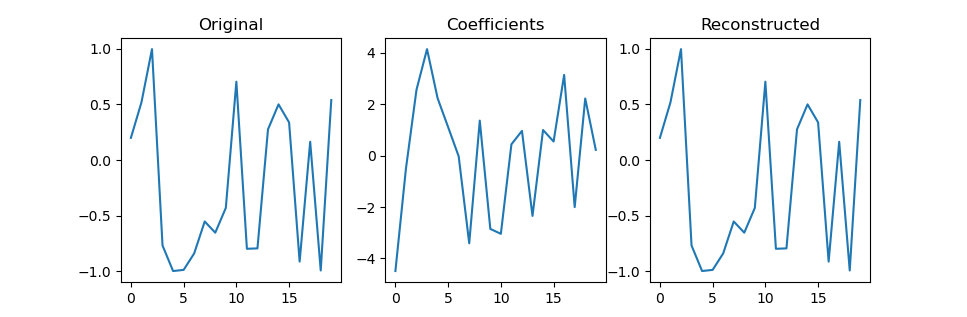

<IPython.core.display.Javascript object>


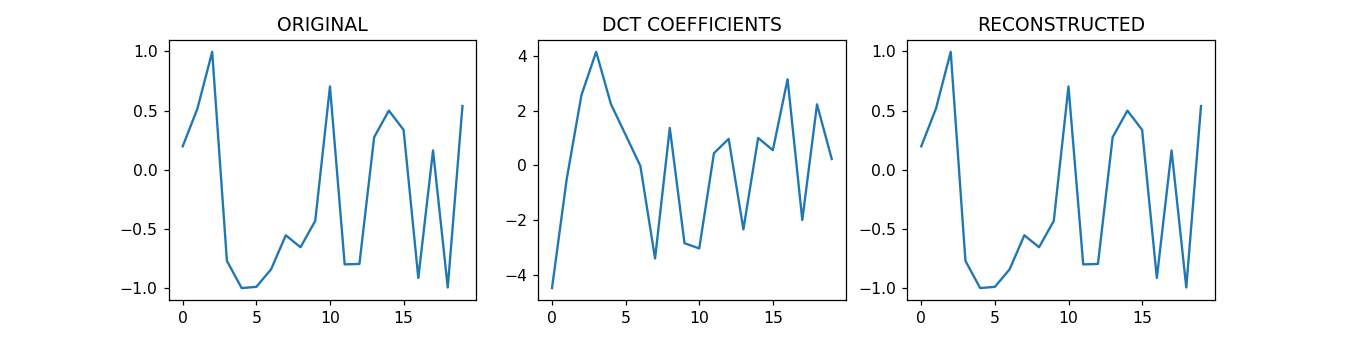

In [9]:
# TODO: write the code
h = np.arange(0, 15, 0.1)
x = np.arange(0, 20, step=1)
y = np.sin(np.exp(x) * 0.2)
y_coef = my_dct(y)
reconstructed = my_idct(y_coef)

_, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].plot(x, y)
ax[0].set_title("ORIGINAL")
ax[1].plot(x, y_coef)
ax[1].set_title("DCT COEFFICIENTS")
ax[2].plot(reconstructed)
ax[2].set_title("RECONSTRUCTED")
plt.show()

 * **(5 points)** The first term ($X_0$) of the DCT is sometimes multiplied by $\frac{1}{\sqrt{2}}$ and the resulting matrix is multiplied by an overall scale factor of $\sqrt{\frac{2}{N}}$. This makes the matrix orthogonal and allows the DCT (and the IDCT) to be performed by matrix multiplication. Write a ``dct_coef`` function that takes a size $N$ and returns a $N\times N$ matrix with the DCT coefficients. If the matrix is scaled correctly it should be orthogonal (i.e. $\mathbf{M}\mathbf{M}^\top=\mathbf{I}$). You can check the implementation details for scaling on <a href="https://en.wikipedia.org/wiki/Discrete_cosine_transform#DCT-II">Wikipedia</a>. The DCT can then be calculated by multiplying a signal $x$ by the DCT coefficient matrix $\mathbf{M}$. The same holds for the IDCT, except that it requires multiplication by the transpose of the matrix $\mathbf{M}$.

    $$
    y = \mathbf{M}x^\top \\
    \hat{x} = (\mathbf{M}^\top y)^\top
    $$

    Using ``dct_coef`` write alternate implementations of ``my_dct`` and ``dct_idct`` and test if they work.

[[ 0.354  0.354  0.354  0.354  0.354  0.354  0.354  0.354]
 [ 0.49   0.416  0.278  0.098 -0.098 -0.278 -0.416 -0.49 ]
 [ 0.462  0.191 -0.191 -0.462 -0.462 -0.191  0.191  0.462]
 [ 0.416 -0.098 -0.49  -0.278  0.278  0.49   0.098 -0.416]
 [ 0.354 -0.354 -0.354  0.354  0.354 -0.354 -0.354  0.354]
 [ 0.278 -0.49   0.098  0.416 -0.416 -0.098  0.49  -0.278]
 [ 0.191 -0.462  0.462 -0.191 -0.191  0.462 -0.462  0.191]
 [ 0.098 -0.278  0.416 -0.49   0.49  -0.416  0.278 -0.098]]
[[ 0.354  0.49   0.462  0.416  0.354  0.278  0.191  0.098]
 [ 0.354  0.416  0.191 -0.098 -0.354 -0.49  -0.462 -0.278]
 [ 0.354  0.278 -0.191 -0.49  -0.354  0.098  0.462  0.416]
 [ 0.354  0.098 -0.462 -0.278  0.354  0.416 -0.191 -0.49 ]
 [ 0.354 -0.098 -0.462  0.278  0.354 -0.416 -0.191  0.49 ]
 [ 0.354 -0.278 -0.191  0.49  -0.354 -0.098  0.462 -0.416]
 [ 0.354 -0.416  0.191  0.098 -0.354  0.49  -0.462  0.278]
 [ 0.354 -0.49   0.462 -0.416  0.354 -0.278  0.191 -0.098]]


<IPython.core.display.Javascript object>


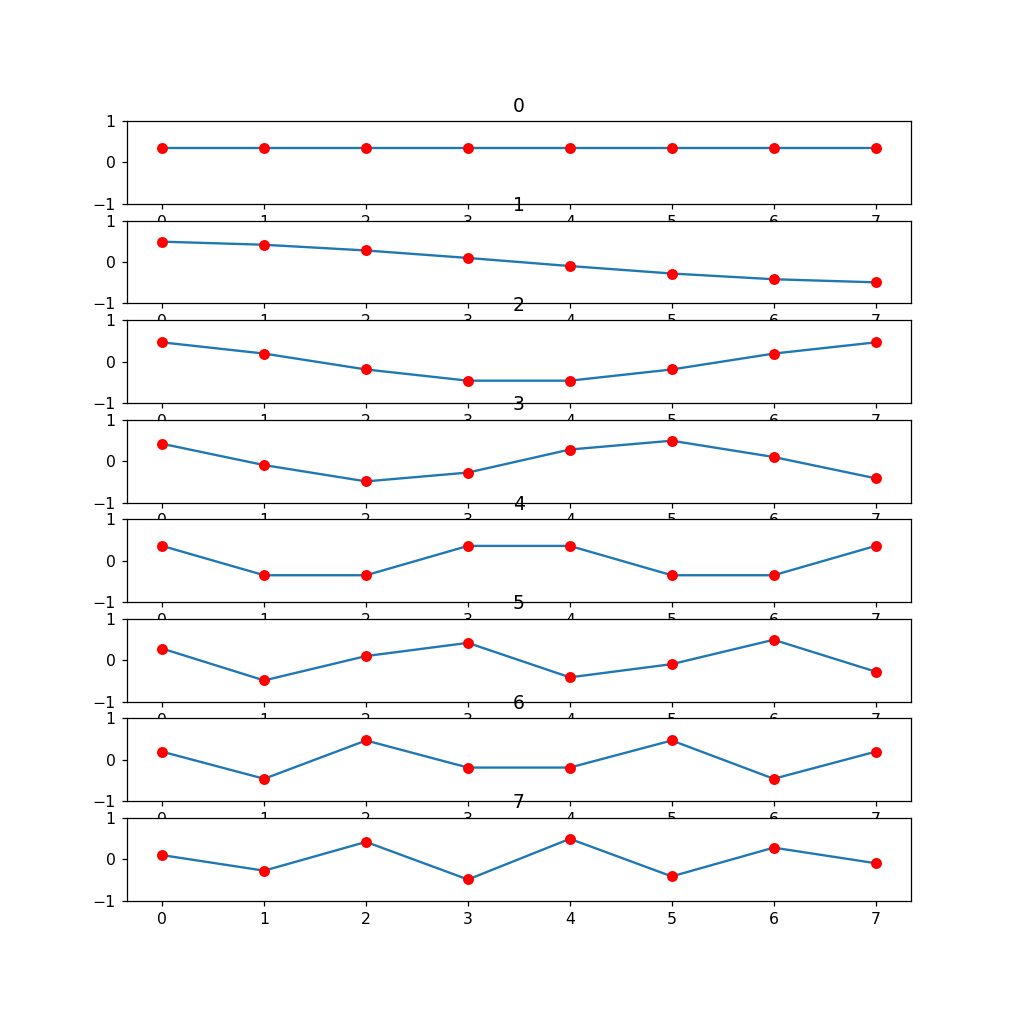

In [10]:
# TODO: write the code here
def dct_coef(N):
    # returns size x size matrix with DCT coefficients
    dct = np.zeros((N, N))
    for n in range(N):
        dct[0, n] = math.sqrt(2/N) / math.sqrt(2)
    for k in range(1, N):
        for n in range(N):
            dct[k, n] = math.sqrt(2/N) * np.cos((np.pi/N) * k * (n + 0.5))
    np.set_printoptions(precision = 3)
    return dct

N = 8
dct = dct_coef(N)
print(dct)

dct_transpose = dct.transpose()
print(dct_transpose)

assert dct.all() == dct_transpose.all()

# plt.figure(figsize=(9, 12))
_, ax = plt.subplots(8, 1, figsize=(9, 9))

for n in range(N):
    ax[n].set_ylim((-1, 1))
    ax[n].set_title(n)
    ax[n].plot(dct[n, :])
    ax[n].plot(dct[n, :], 'ro')

 * The DCT on two-dimensional data can be performed either by first calculating the 1D DCT on matrix rows and then on matrix columns (or vice versa) or by applying the formula directly.

    $$
    X_{k_1,k_2} = C_{k_1} C_{k_2} \sum_{n_1=0}^{N_1-1} \sum_{n_2=0}^{N_2-1} x_{n_1,n_2} \cos{\bigg(  \frac{\pi}{N_1} \Big( n_1 + \frac{1}{2} \Big) k_1 \bigg)} \cos{\bigg(  \frac{\pi}{N_2} \Big( n_2 + \frac{1}{2} \Big) k_2 \bigg) \quad k_1 = 0,\dots, N_1-1 \quad k_2 = 0,\dots, N_2-1\\}
    $$

    where $x_{n_1,n_2}$ denotes the element at $n_1$-th row and $n_2$-th column of the input matrix, while $N_1$ and $N_2$ denote the number of rows and the number of columns of the input matrix, respectively. The $C_{x}$ is defined as step function $C_{x} = \frac{1}{\sqrt{2}}$ if $x = 0$ and $C_{x} = 1$ otherwise.

    The inverse of DCT is defined similarly as:

    $$
    x_{n_{1},n_{2}}=\sum _{k_{1}=0}^{N_{1}-1}\sum _{k_{2}=0}^{N_{2}-1}  C_{k_1} C_{k_2} X_{k_{1},k_{2}} \cos \left[{\frac {\pi }{N_{1}}}\left(n_{1}+{\frac {1}{2}}\right)k_{1}\right]\cos \left[{\frac {\pi }{N_{2}}}\left(n_{2}+{\frac {1}{2}}\right)k_{2}\right], \quad {\text{for }}n_{i}=0,1,2,\dots ,N_{i}-1"
    $$

     Plot the 2D basis functions. The result should look like this:

    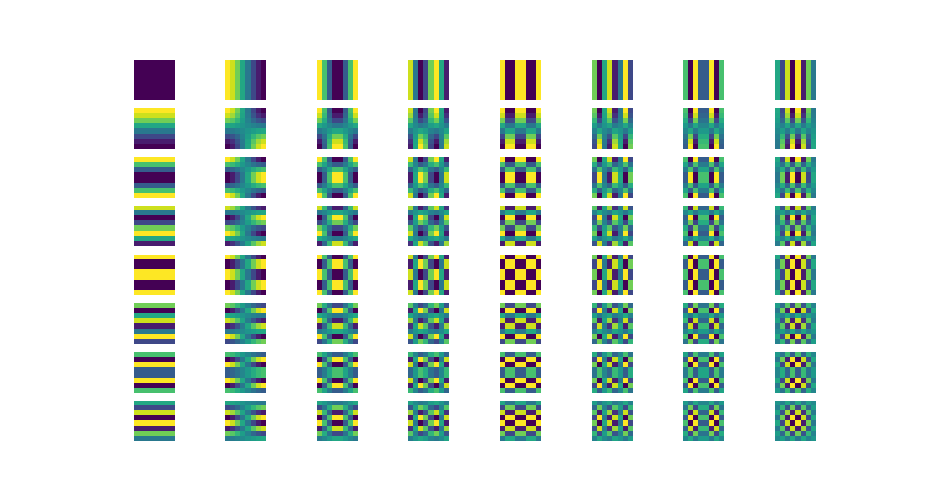


<IPython.core.display.Javascript object>


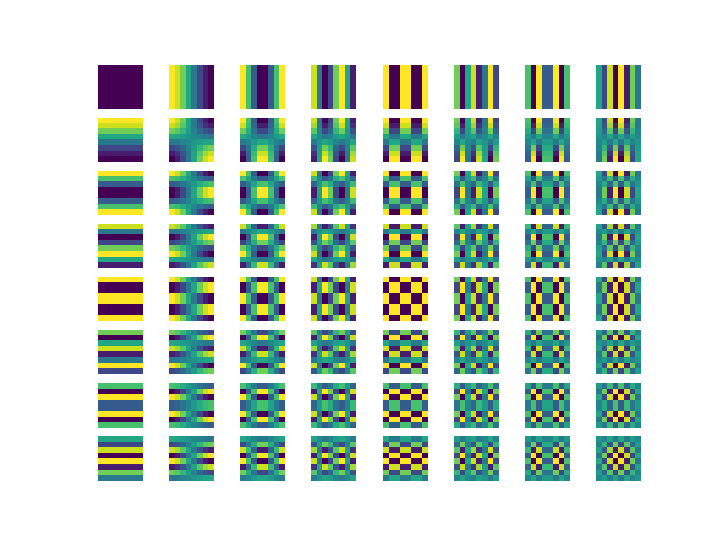

In [11]:
# formule https://www.mathworks.com/help/images/discrete-cosine-transform.html
from math import cos, sqrt, pi

def nov_dct(x, y, u, v, n):
    # Normalizacija
    def alpha(a):
        if a==0:
            return sqrt(1/n)
        else:
            return sqrt(2/n)
    # formula: x=m, y=n, n=M, p=u, q=v
    cos1 = cos( ((2*x+1) * (u*pi)) / (2*n))
    cos2 = cos( ((2*y+1) * (v*pi)) / (2*n))
    return alpha(u) * alpha(v) * cos1 * cos2

def make_dct_basis_image(u, v, n):
    basisImage = np.zeros((n,n))
    for y in range(0, n):
        for x in range(0, n):
            basisImage[y,x] = nov_dct(x, y, u, v, n)
    return basisImage

n = 8

images = []
for v in range(0, n):
    for u in range(0, n):
        basisImage = make_dct_basis_image(u, v, n)
        images.append(basisImage)

plt.figure()
for i in range(0, len(images)):
    plt.subplot(n, n, i+1)
    plt.axis('off')
    plt.imshow(images[i])

plt.savefig('2d_basis_functions.png')
plt.show()

 * Implement the ``my_dct2`` and ``my_idct2`` functions that perform the DCT and IDCT on 2D matrices.

In [12]:
# TODO: Compute the 2D DCT transform of the input matrix 
def my_dct2(input_matrix):
    Y = np.ndarray(input_matrix.shape)    
    (M, N) = input_matrix.shape
    
    c1 = np.ones(M)
    c1[0] = 1/math.sqrt(2)
    c2 = np.ones(N)
    c2[0] = 1/math.sqrt(2)
    C = np.multiply(c1.reshape((-1, 1)), c2)
    
    for i in range(0, M):
        Y[i, :] = my_dct(input_matrix[i, :])
    
    for i in range(0, N):
        Y[:, i] = my_dct(Y[:, i])
        
    return np.multiply(C, Y)

Y = np.array([[1, 2, 3, 4],
              [2, 3, 4, 5],
              [3, 4, 5, 6],
              [4, 5, 6, 7]])

res = my_dct2(Y)
print(res)

[[ 3.200e+01 -8.922e+00 -3.140e-15 -6.341e-01]
 [-8.922e+00 -4.441e-16  3.399e-16  1.082e-15]
 [-3.768e-15  4.441e-16  6.280e-16  8.327e-16]
 [-6.341e-01  1.998e-15 -8.206e-16 -9.021e-16]]


In [13]:
# TODO: Compute the inverse 2D DCT tranformation of the input matrix
def my_idct2(input_matrix): 
    (M, N) = input_matrix.shape
    
    c1 = np.ones(M)
    c1[0] = 1/math.sqrt(2)
    c2 = np.ones(N)
    c2[0] = 1/math.sqrt(2)
    C = np.multiply(c1.reshape((-1, 1)), c2)
    
    Y = np.divide(input_matrix, C)
    
    for i in range(0, M):
        Y[i, :] = my_idct(Y[i, :])
    
    for i in range(0, N):
        Y[:, i] = my_idct(Y[:, i])
        
    return Y

ires = my_idct2(res)
print(ires)

[[1. 2. 3. 4.]
 [2. 3. 4. 5.]
 [3. 4. 5. 6.]
 [4. 5. 6. 7.]]


 * Reconstruct an image from 2D DCT coefficients. Open a grayscale image (e.g. image *A.bmp*) and calculate its 2D DCT using `my_dct2`. Visualize the coefficient matrix. Convert the image back using `my_idct2`.

    Comment on the contribution of lower and higher frequency components to the reconstruction of the image. Which frequencies are more important perceptually? Slightly modify several coefficients to see the effect.

    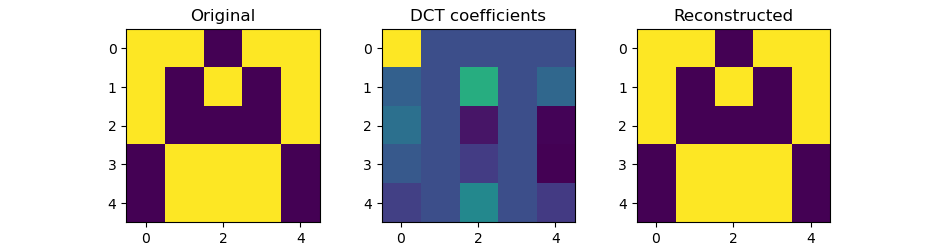

[[1 1 0 1 1]
 [1 0 1 0 1]
 [1 0 0 0 1]
 [0 1 1 1 0]
 [0 1 1 1 0]]


<IPython.core.display.Javascript object>


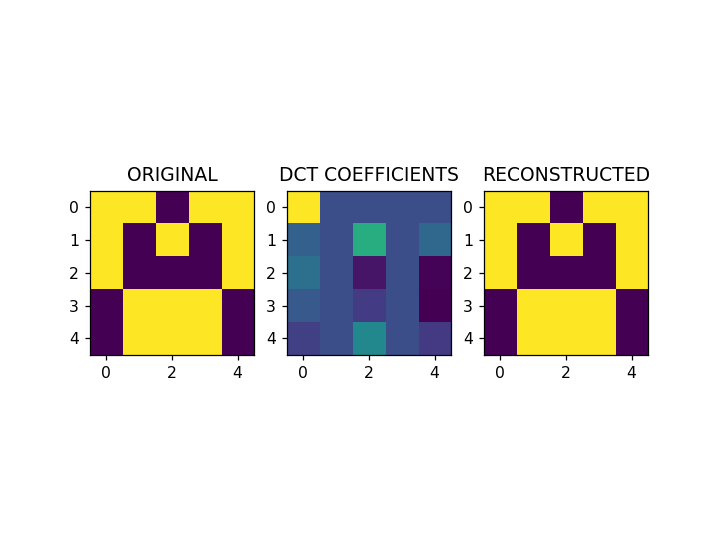

In [14]:
from scipy.fftpack import dct, idct

A = io.imread("A.bmp")
print(A)

# TODO: convert image to DCT coefficients
coef = my_dct2(A)
reconstructed = my_idct2(coef)

plt.figure()
plt.subplot(131)
plt.imshow(A)
plt.title("ORIGINAL")
plt.subplot(132)
plt.imshow(coef)
plt.title("DCT COEFFICIENTS")
plt.subplot(133)
plt.imshow(reconstructed)
plt.title("RECONSTRUCTED")
plt.show()

* Load one of the images from one of the previous exercises, convert it to grayscale. Then cut out several square blocks of 24x24 pixels and perform encoding/decoding using DCT. Test, how is the content modified if you modify the entire DCT coefficent matrix, and how if you modify the three quarters that denote the high frequency coefficients (all except top-left quarter). Apply the quantization formula that is written in the lecture slides. 

    This task is complete if you do this for five different blocks (try to find different blocks, uniform region, edges, etc.) and visualize (1) original block, (2) DCT coefficients, (3) reconstruction with quantized DCT coefficients, (4) reconstruction with quantized high-frequency components.

<IPython.core.display.Javascript object>


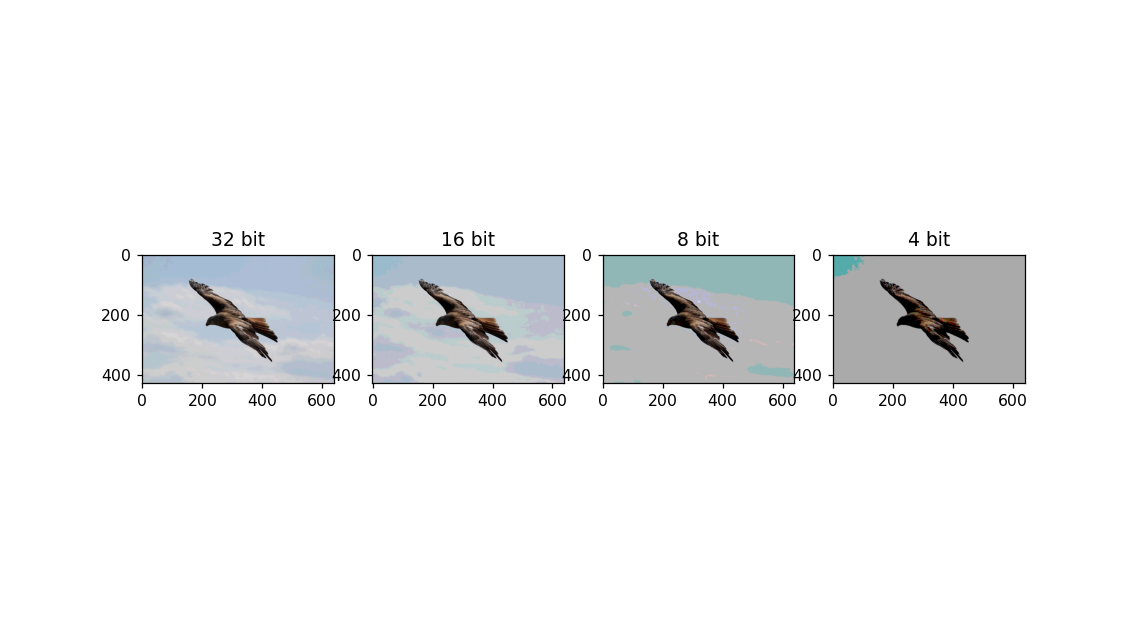

<IPython.core.display.Javascript object>


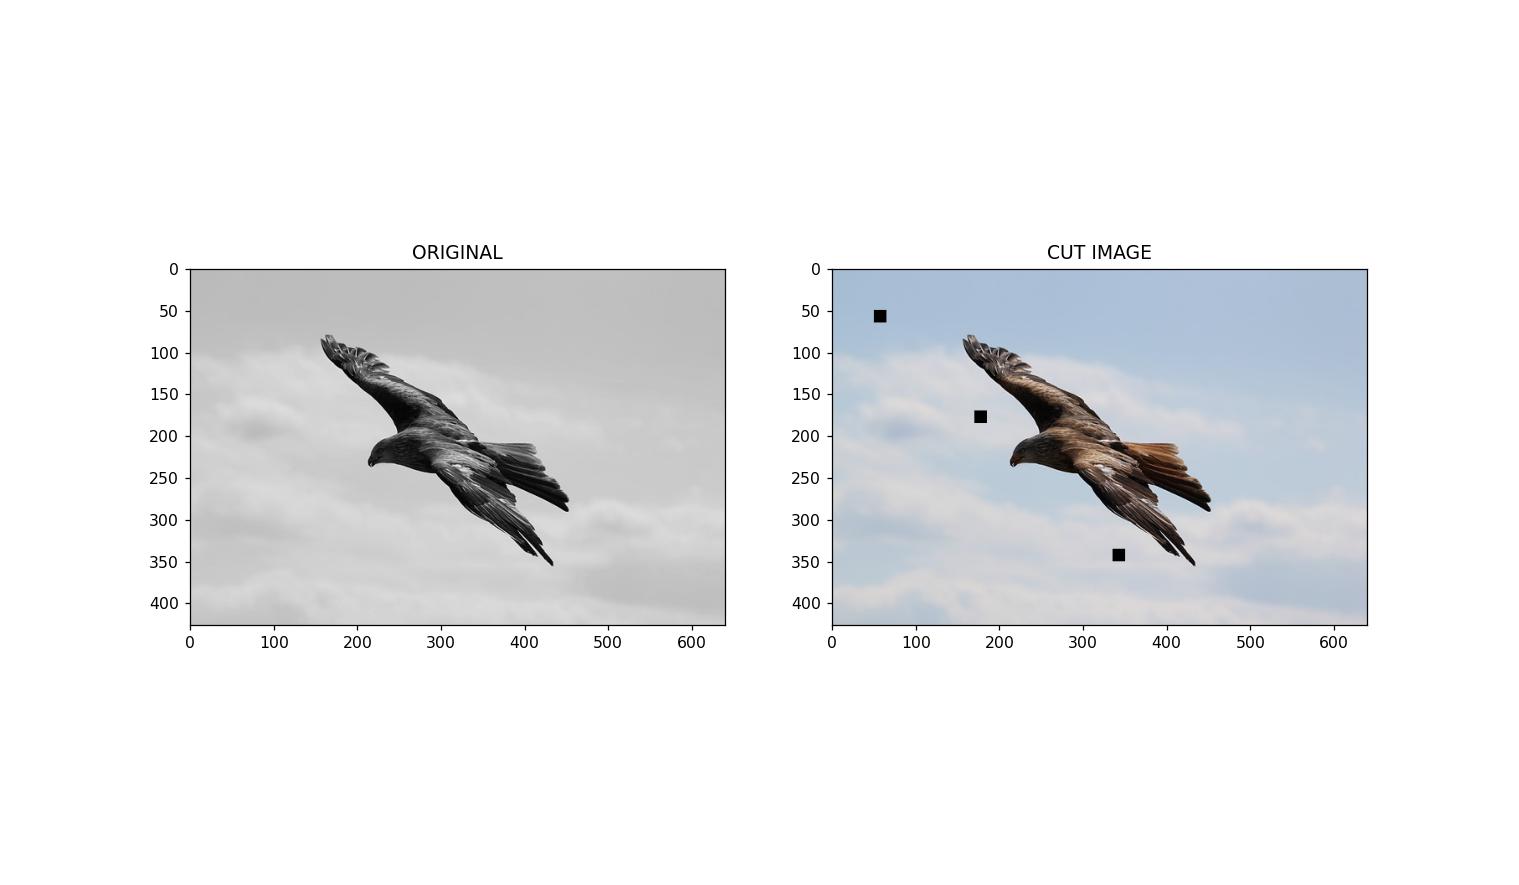

In [40]:
import random

#TODO: write your code here
eagle = io.imread("eagle.jpg")
eagle_gray = color.rgb2gray(eagle) * 255

# 32bit quantization
im = eagle.copy()
bins = np.linspace(0, im.max(), 2**5)
digi_image1 = np.digitize(im, bins)
digi_image1 = (np.vectorize(bins.tolist().__getitem__)(digi_image1-1).astype(int))

# 16bit quantization
bins = np.linspace(0, im.max(), 2**4)
digi_image2 = np.digitize(im, bins)
digi_image2 = (np.vectorize(bins.tolist().__getitem__)(digi_image2-1).astype(int))

# 8bit quantization
bins = np.linspace(0, im.max(), 2**3)
digi_image3 = np.digitize(im, bins)
digi_image3 = (np.vectorize(bins.tolist().__getitem__)(digi_image3-1).astype(int))

# 4bit quantization
bins = np.linspace(0, im.max(), 2**2)
digi_image4 = np.digitize(im, bins)
digi_image4 = (np.vectorize(bins.tolist().__getitem__)(digi_image4-1).astype(int))

_, ax = plt.subplots(1, 4, figsize=(9,5))
ax[0].imshow(digi_image1, cmap = plt.cm.gray)
ax[0].set_title("32 bit")
ax[1].imshow(digi_image2, cmap = plt.cm.gray)
ax[1].set_title("16 bit")
ax[2].imshow(digi_image3, cmap = plt.cm.gray)
ax[2].set_title("8 bit")
ax[3].imshow(digi_image4, cmap = plt.cm.gray)
ax[3].set_title("4 bit")
plt.show()


# eagle_a = np.array(eagle, dtype=np.float64) / 255
# h, w, d = eagle_a.shape
# eagle_array = np.reshape(eagle, (h*w, d))
# print(eagle_array)
# image_array_sample = np.random.shuffle(eagle_array)[:1000]
# kmeans = KMeans(n_clusters=n_colors).fit(image_array_sample)
# labels = kmeans.predict(eagle_array)

# out = np.zeros((h, w, d))
# idx = 0
# for i in range(h):
#     for j in range(w):
#         out[i][j] = kmeans.cluster_centers_[labels[idx]]
#         idx += 1

cut_eagle = eagle.copy()
cut_eagle[50:65, 50:65] = 0
cut_eagle[170:185, 170:185] = 0
cut_eagle[335:350, 335:350] = 0

block1 = eagle[50:65, 50:65]
block2 = eagle[170:185, 170:185]
block3 = eagle[335:350, 335:350]

_, ax = plt.subplots(1, 2, figsize=(12,7))
ax[0].imshow(eagle_gray, cmap = plt.cm.gray)
ax[0].set_title("ORIGINAL")
ax[1].imshow(cut_eagle, cmap = plt.cm.gray)
ax[1].set_title("CUT IMAGE")
plt.show()

## Assignment 3: The JPEG Pipeline

In this assignment you will implement the main part of the JPEG compression algorithm. The image needs to be split into $8 \times8$ blocks and DCT must be performed on each of them. The coefficients are then quantized using a quantization matrix. The result is finally losslessly compressed using entropy encoding.

Note that this assignment is entierly optional, each task has a certain number of points, but the tasks are dependent on the previous ones.

Use the provided ```quantization_matrix``` function to generate different quantization matrices. The function accepts an argument on the interval $[1,100]$ which can be interpreted as the output image quality in percentages. How does the matrix change with different inputs? Experiment with a few values.

In [16]:
# Generation of different quality quantization matrices, based on detail level
def quantization_matrix(alpha_image_quality):    
    
    # For this example we use the standard quantization matrix proposed by the Independent JPEG Group (IJG)
    Q = np.array([[16,  11,  10,  16,  24,  40,  51,  61],
                  [12,  12,  14,  19,  26,  58,  60,  55],
                  [14,  13,  16,  24,  40,  57,  69,  56],
                  [14,  17,  22,  29,  51,  87,  80,  62],
                  [18,  22,  37,  56,  68, 109, 103,  77],
                  [24,  35,  55,  64,  81, 104, 113,  92],
                  [49,  64,  78,  87, 103, 121, 120, 101],
                  [72,  92,  95,  98, 112, 100, 103,  99]])
    
    if(alpha_image_quality < 50):
        s = 5000 / alpha_image_quality
    else:
        s = 200 - 2 * alpha_image_quality
    
    R = np.floor( (s * Q + 50) / 100 )
    R[R == 0] = 1
    
    return R

In [17]:
print(quantization_matrix(30))
print(quantization_matrix(50))
print(quantization_matrix(70))
print(quantization_matrix(100))

[[ 27.  18.  17.  27.  40.  67.  85. 102.]
 [ 20.  20.  23.  32.  43.  97. 100.  92.]
 [ 23.  22.  27.  40.  67.  95. 115.  93.]
 [ 23.  28.  37.  48.  85. 145. 133. 103.]
 [ 30.  37.  62.  93. 113. 182. 172. 128.]
 [ 40.  58.  92. 107. 135. 173. 188. 153.]
 [ 82. 107. 130. 145. 172. 202. 200. 168.]
 [120. 153. 158. 163. 187. 167. 172. 165.]]
[[ 16.  11.  10.  16.  24.  40.  51.  61.]
 [ 12.  12.  14.  19.  26.  58.  60.  55.]
 [ 14.  13.  16.  24.  40.  57.  69.  56.]
 [ 14.  17.  22.  29.  51.  87.  80.  62.]
 [ 18.  22.  37.  56.  68. 109. 103.  77.]
 [ 24.  35.  55.  64.  81. 104. 113.  92.]
 [ 49.  64.  78.  87. 103. 121. 120. 101.]
 [ 72.  92.  95.  98. 112. 100. 103.  99.]]
[[10.  7.  6. 10. 14. 24. 31. 37.]
 [ 7.  7.  8. 11. 16. 35. 36. 33.]
 [ 8.  8. 10. 14. 24. 34. 41. 34.]
 [ 8. 10. 13. 17. 31. 52. 48. 37.]
 [11. 13. 22. 34. 41. 65. 62. 46.]
 [14. 21. 33. 38. 49. 62. 68. 55.]
 [29. 38. 47. 52. 62. 73. 72. 61.]
 [43. 55. 57. 59. 67. 60. 62. 59.]]
[[1. 1. 1. 1. 1. 1. 1. 1.]
 [

* Split your input image into $8\times8$ blocks.

    For each of the blocks, do:
     1. Subtract $128$ (take care of the data type, do not use uint8 here)
     2. Calculate the 2D DCT
     * Perform element-wise division by the quantization matrix $Q$
     * Round the coefficients to quantize them
     * Do element-wise multiplication with $Q$.
     * Save the quantized coefficients in a separate matrix
     * Calculate the 2D IDCT
     * Add $128$

  Display the image reconstructed from quantized blocks. Display the difference to the original. Comment on the distribution of the differences and the reduction in image quality (try different levels of quantization).

  Use the image *tiger.bmp* to test your algorithm.

<IPython.core.display.Javascript object>


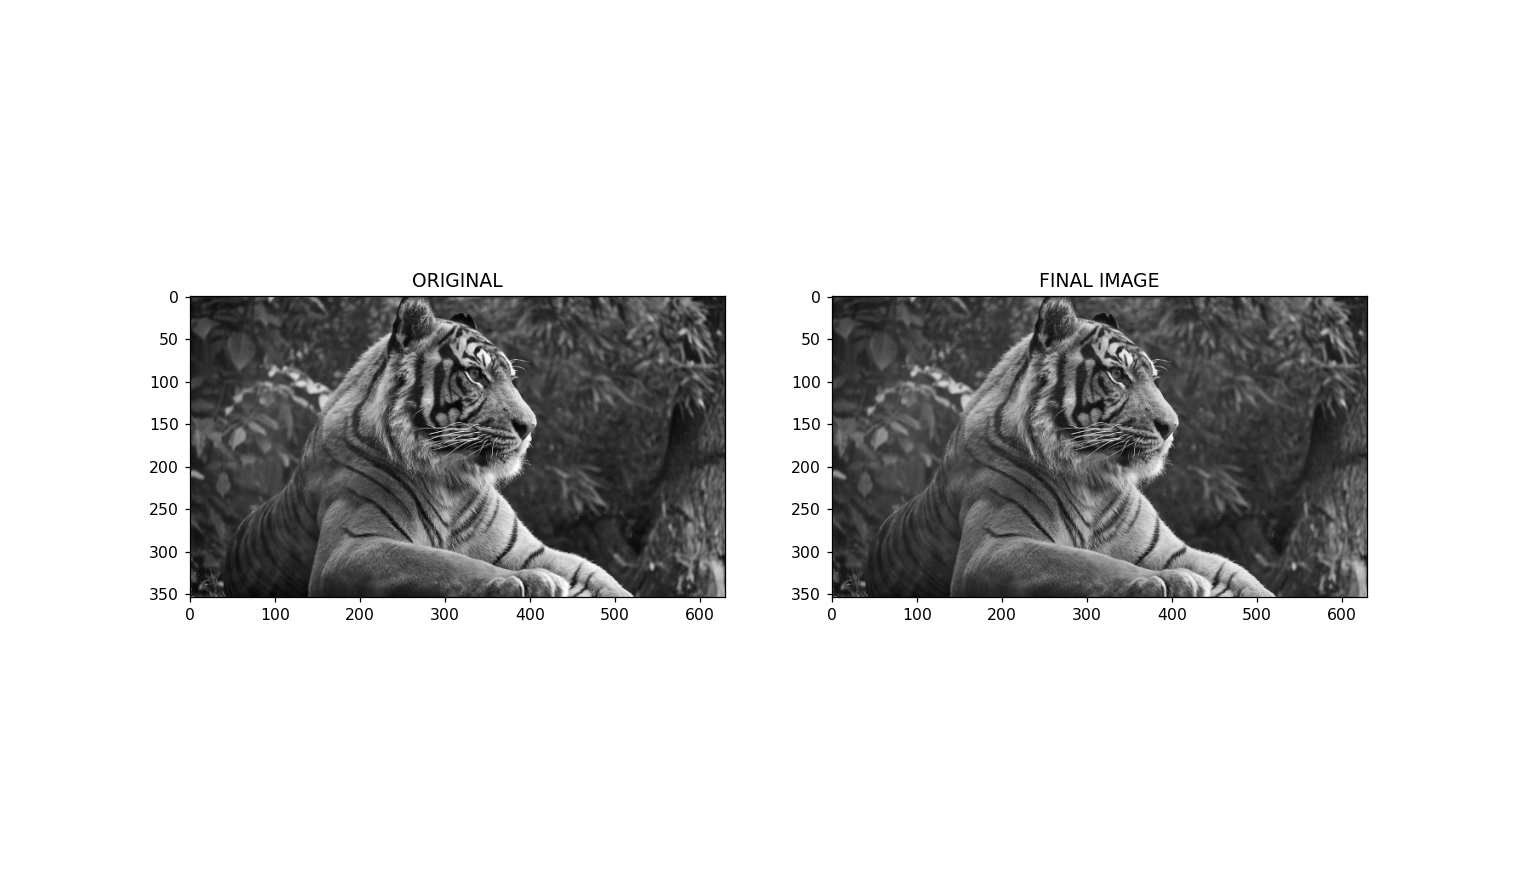

In [18]:
# TODO: Add code here
tiger = io.imread("tiger.bmp")
tiger_gray = color.rgb2gray(tiger) * 255

# treba popaddat sliko, ker ni deljiva z 8
# np.pad vzame pad spredaj in zadaj zato je pad_h/w deljen z 2
pad_tiger = np.pad(tiger_gray, ((0,padding(tiger_gray.shape[0], 8)), (0,padding(tiger_gray.shape[1], 8))))

num_blocks = 8
level_q = 50
q = quantization_matrix(level_q)

for col in np.arange(0, pad_tiger.shape[1], step=num_blocks):
    for row in np.arange(0, pad_tiger.shape[0], step=num_blocks):
        block = pad_tiger[row : row + num_blocks, col : col + num_blocks]
        if row==360: print(block)
        block = block - 128           # Subtract  128
        block = my_dct2(block)        # Calculate the 2D DCT
        block = np.divide(block, q)   # Perform element-wise division by the quantization matrix  𝑄
        block = np.around(block)       # Round the coefficients to quantize them
        block = np.multiply(block, q) # Do element-wise multiplication with  𝑄
        block = my_idct2(block)
        block += 128
        pad_tiger[row : row + num_blocks, col : col + num_blocks] = block # Save the quantized coefficients in a separate matrix
        
result = pad_tiger[:tiger_gray.shape[0], :tiger_gray.shape[1]]

_, ax = plt.subplots(1, 2, figsize=(12,7))
ax[0].imshow(tiger_gray, cmap = plt.cm.gray)
ax[0].set_title("ORIGINAL")
ax[1].imshow(result, cmap = plt.cm.gray)
ax[1].set_title("FINAL IMAGE")
plt.show()

* **(5 points)** Convert the image into YCbCr color space (e.g. using `skimage.color.rgb2ycbcr`), then subsample the color channels. Then reverse the process and reconstruct the image. Find representative images from previous exercises and comment on the difference using different factors of subsampling. Do the same with the $Y$ channel and comment on the differences. Save some examples images.

<IPython.core.display.Javascript object>


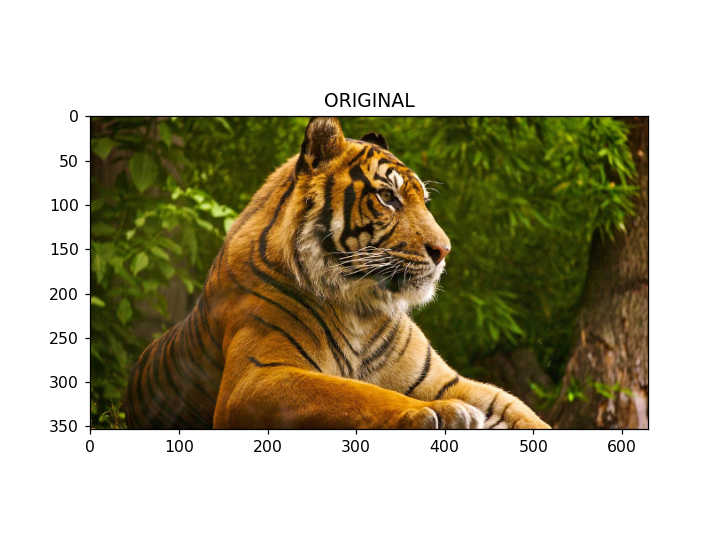

In [19]:
from skimage.color import rgb2ycbcr
import cv2

# convert image into YCbCr color space
tiger = io.imread("tiger.bmp")
y_tiger = rgb2ycbcr(tiger)

plt.figure()
plt.imshow(tiger)
plt.title("ORIGINAL")
plt.show()

# plt.figure()
# plt.imshow(y_tiger[:, :, 2])
# plt.title("YCBCR")
# plt.show()

# subsample color channels
# I will use chroma subsampling and later luma



# subsample vertical and horizontal
# SSV = 2
# SSH = 2

# # chrominance channels are filtered using (2x2) box filter (average filter)
# crf = cv2.boxFilter(y_tiger[:,:,1], ddepth = -1, ksize = (2,2))
# cbf = cv2.boxFilter(y_tiger[:,:,2], ddepth = -1, ksize = (2,2))
# crsub = crf[::SSV,::SSH]
# cbsub = cbf[::SSV,::SSH]

# # store subsampled channels in list
# imSub=[y_tiger[:,:,0], crsub, cbsub]

# print(imSub)

# plt.figure()
# plt.imshow(cbsub)
# plt.title("SUBSAMPLED")
# plt.show()


# reverse the process and reconstruct the image

# brightness component—or luma—is usually denoted Y


# The following are the most common combinations for chroma subsampling:

# 4:4:4 is used for an uncompressed signal without color reduction. You get full horizontal and vertical color resolution without quality loss. There's also 4:4:4:4, where the fourth four is a transparency channel.
# 4:2:2 has half the chroma of 4:4:4, cutting the horizontal color resolution in half compared with luma. It decreases the file size of an uncompressed signal by one-third, with little to no compression artifacts. As such, 4:2:2 is often used in gaming and professional video formats like Digital Betacam, DVCPRO 50, and MPEG-2.
# 4:2:0 transports one-quarter of the luma samples. Only half of the pixels in the first row are sampled, and the second row is discarded. With the sampling rate halved horizontally and vertically, 4:2:0 practically retains lossless visual quality. Those features have helped turn it into an industry standard for movies, TV shows, and sports.

* **(10 points)** Modify the code to compress the entire matrix of quantized coefficients as it was discussed at the lectures to a byte stream. Comment on the compression ratio for different levels of quantization. 

   **Question:** Why can quantized images be stored using less space?

In [20]:
# TODO: Write code here